In [154]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [155]:
dd = pd.read_csv('data/data_dictionary.csv')
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [156]:
X = train.drop(['efs', 'efs_time'], axis=1)
y = train[['efs', 'efs_time', 'race_group']]

## Data Cleaning

In [157]:
df = pd.concat([X, test])

'''
# many missing data
df.drop('tce_match', axis=1, inplace=True)

# self encode !!
df['mrd_hct'] = df['mrd_hct'].fillna('Unknown')
df['mrd_hct'] = df['mrd_hct'].map({'Negative': 0, 'Positive': 1, 'Unknown': -1})

# Fill missing values with the mode within `dri_score`
df['cyto_score_detail'] = df.groupby('dri_score')['cyto_score_detail'] \
                            .transform(lambda group: group.fillna(group.mode()[0] if not group.mode().empty else 'Unknown'))

'''

categorical_cols = ['dri_score', 'cyto_score', 'diabetes', 'arrhythmia', 'cmv_status', 'rituximab', 'obesity', 
                    'in_vivo_tcd', 'tce_match', 'graft_type', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 
                    'ethnicity', 'conditioning_intensity', 'mrd_hct', 'hla_match_c_high', 'hla_match_b_low', 
                    'peptic_ulcer', 'prior_tumor', 'hepatic_severe', 'sex_match', 'gvhd_proph', 'rheum_issue', 
                    'hla_match_b_high', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related']

# Ensure columns are numeric before applying median
numerical_cols = df.select_dtypes(include=['number']).columns

for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())

# For categorical columns, fill with 'Unknown'
categorical_cols = df.select_dtypes(exclude=['number']).columns

'''for col in categorical_cols:
    df[col] = df[col].fillna('Unknown')

'''
# If 'year_hct' or 'age_at_hct' is missing, you could fill with median value
df['age_at_hct'].fillna(df['age_at_hct'].median(), inplace=True)
df['year_hct'].fillna(df['year_hct'].mode()[0], inplace=True)  # Use mode for most frequent year

# For categorical columns where a specific value indicates missing data
df['dri_score'].fillna('Missing disease status', inplace=True)
df['cyto_score'].fillna('Not tested', inplace=True)
df['diabetes'].fillna('Not done', inplace=True)


print("Check for missing data in train set:")
print(df.isnull().sum().sort_values(ascending=False))

Check for missing data in train set:
tce_match                 18998
mrd_hct                   16599
cyto_score_detail         11925
tce_div_match             11397
tce_imm_match             11134
conditioning_intensity     4791
cardiac                    2542
peptic_ulcer               2419
arrhythmia                 2202
rheum_issue                2183
rituximab                  2148
pulm_severe                2135
psych_disturb              2062
pulm_moderate              2047
hepatic_mild               1917
renal_issue                1915
hepatic_severe             1871
obesity                    1760
prior_tumor                1678
melphalan_dose             1405
cmv_status                  634
ethnicity                   587
sex_match                   261
vent_hist                   259
in_vivo_tcd                 225
gvhd_proph                  225
donor_related               158
age_at_hct                    0
ID                            0
race_group                    0
hla

C:\Users\yardz\AppData\Local\Temp\ipykernel_3312\2783288663.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age_at_hct'].fillna(df['age_at_hct'].median(), inplace=True)
C:\Users\yardz\AppData\Local\Temp\ipykernel_3312\2783288663.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 

<Axes: >

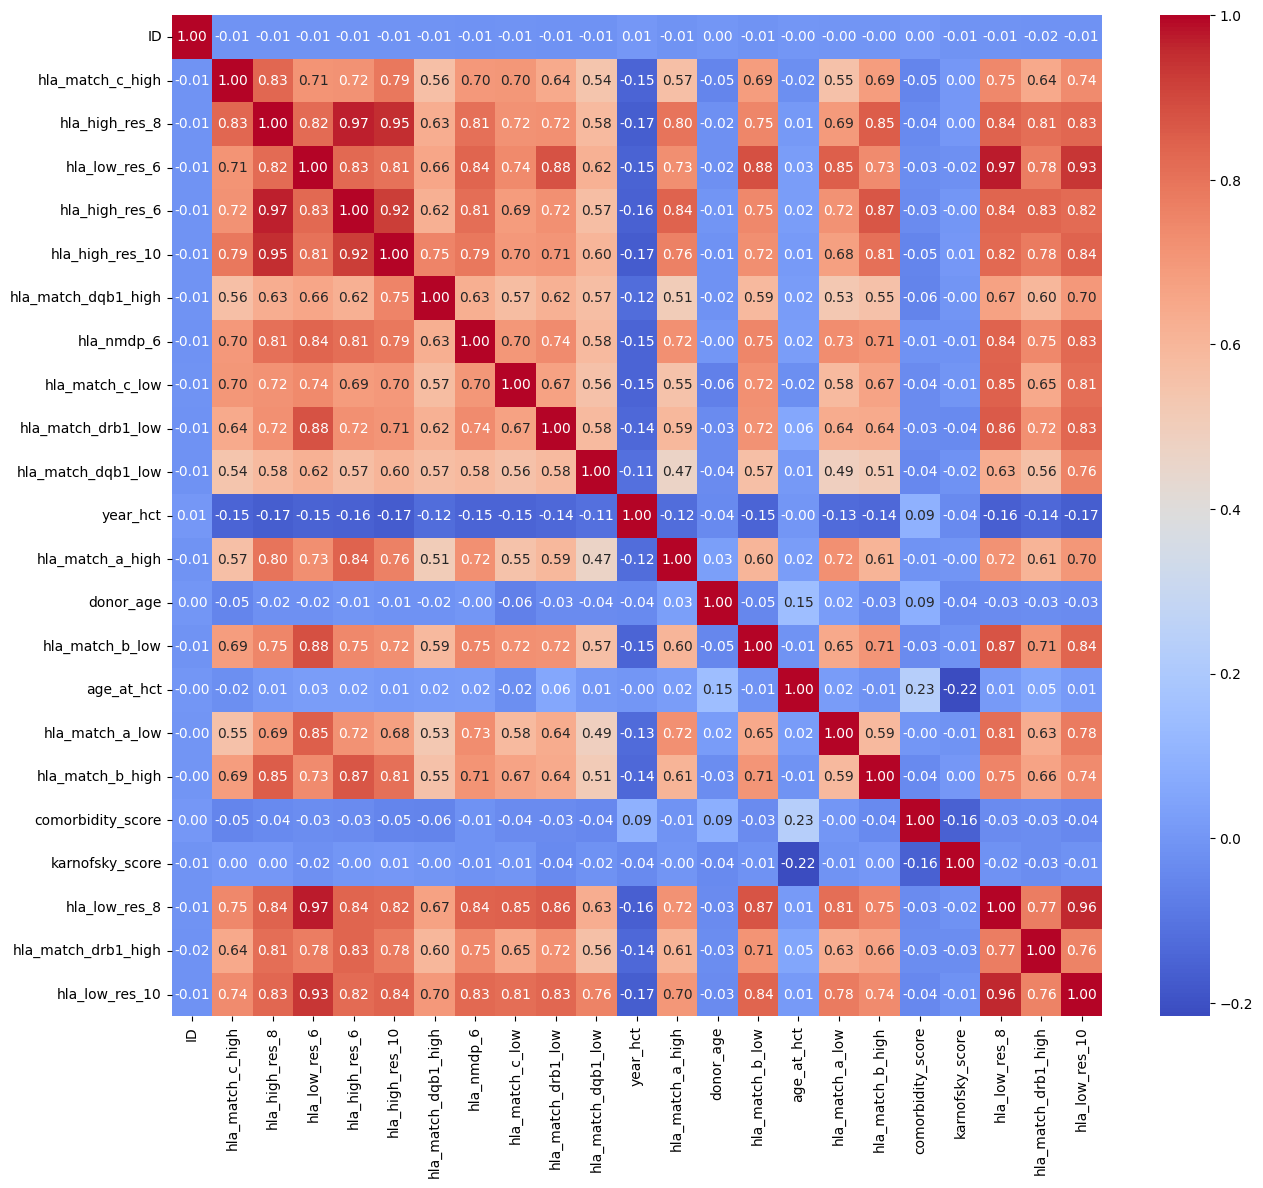

In [158]:
import seaborn as sns
from matplotlib import pyplot as plt
corr_matrix = pd.DataFrame(df.select_dtypes(include=['number']).corr())

plt.figure(figsize=(15, 13)) 
sns.heatmap(data=corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")

In [159]:
# Feature Engineering: Count missing values per row
df['missing_count'] = df.isnull().sum(axis=1)

# Feature Engineering: Combine HLA match scores into a single metric
hla_cols = [
    'hla_high_res_6', 'hla_high_res_8', 'hla_high_res_10',
    'hla_match_a_high', 'hla_match_b_high', 'hla_match_c_high',
    'hla_match_dqb1_high', 'hla_low_res_6', 'hla_low_res_8'
]
df['hla_match_avg'] = df[hla_cols].mean(axis=1)

# Feature Engineering: Binary feature for high-risk DRI scores
df['dri_high_risk'] = df['dri_score'].apply(
    lambda x: 1 if isinstance(x, str) and ('High' in x or 'Very high' in x) else 0
)

# Feature Engineering: Binary feature for any psychiatric disturbance
df['psych_disturb_binary'] = df['psych_disturb'].apply(lambda x: 1 if x == 'Yes' else 0)

# Feature Engineering: Create a composite comorbidity score
comorbidity_cols = [
    'cardiac', 'renal_issue', 'hepatic_severe', 'pulm_severe', 
    'rheum_issue', 'diabetes', 'obesity', 'vent_hist', 'arrhythmia'
]
df['comorbidity_severity'] = df[comorbidity_cols].apply(
    lambda row: sum([1 for val in row if val == 'Yes']), axis=1
)

# Feature Engineering: Binary feature for severe conditions
df['severe_conditions'] = df[['hepatic_severe', 'pulm_severe', 'renal_issue']].apply(
    lambda row: 1 if 'Yes' in row.values else 0, axis=1
)

# Feature Engineering: Encode donor-recipient sex match as numerical categories
sex_match_mapping = {'M-M': 0, 'F-F': 1, 'M-F': 2, 'F-M': 3, np.nan: -1}
df['sex_match_encoded'] = df['sex_match'].map(sex_match_mapping)

# Feature Engineering: Create interaction features
df['hla_cyto_interaction'] = df['hla_match_c_high'] * df['cyto_score'].apply(
    lambda x: 1 if x == 'Favorable' else 0
)

# Feature Engineering: Extract year from 'year_hct' and categorize into decades
df['year_hct_decade'] = df['year_hct'].apply(lambda x: (x // 10) * 10 if not pd.isnull(x) else np.nan)

# Feature Engineering: Add a risk index based on comorbidity and DRI
df['risk_index'] = df['comorbidity_score'] + df['dri_high_risk']

# Feature Engineering: Binarize CMV status
df['cmv_positive'] = df['cmv_status'].apply(lambda x: 1 if x in ['+/-', '+/+'] else 0)


In [160]:
from sklearn.preprocessing import OneHotEncoder

object_cols = df.select_dtypes(include=['object']).columns

# Apply OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Updated sparse parameter
encoded_array = encoder.fit_transform(df[object_cols])

# Create a DataFrame for the encoded data
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(object_cols), index=df.index)

# Remove original object columns and add the encoded ones
df = pd.concat([df.drop(columns=object_cols), encoded_df], axis=1)

In [161]:
y

,efs,efs_time,race_group
0,0.0,42.356,More than one race
1,1.0,4.672,Asian
2,0.0,19.793,More than one race
3,0.0,102.349,White
4,0.0,16.223,American Indian or Alaska Native
...,...,...,...
28795,0.0,18.633,More than one race
28796,1.0,4.892,Native Hawaiian or other Pacific Islander
28797,0.0,23.157,Native Hawaiian or other Pacific Islander
28798,0.0,52.351,Black or African-American


In [162]:
X = df[:-3]
X_test = df[-3:]

In [163]:
print("Different columns between X and test:")
print(X.shape, X_test.shape)

Different columns between X and test:
(28800, 187) (3, 187)


<Axes: xlabel='timeline'>

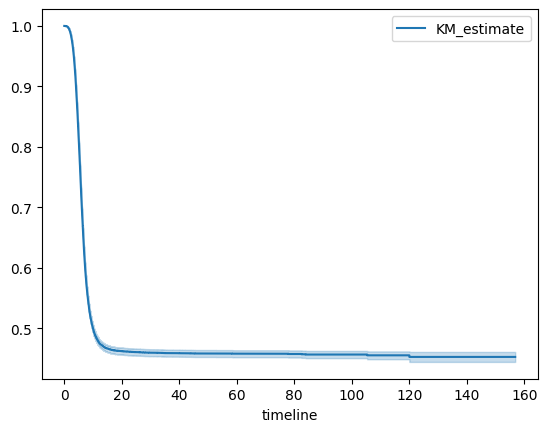

In [170]:
from lifelines import KaplanMeierFitter

# Kaplan-Meier estimation
kmf = KaplanMeierFitter()
kmf.fit(y['efs_time'], event_observed=y['efs'])

# Plot survival curve
kmf.plot_survival_function()

In [169]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

rdc = XGBClassifier(random_state=42)
rdc.fit(X_train, y_train['efs'])

rdc.score(X_val, y_val['efs'])

ValueError: feature_names must be string, and may not contain [, ] or <

In [165]:
preds = rdc.predict(X_val)

fe: 0.6791666666666667,

In [166]:
preds

array([1., 0., 1., ..., 0., 1., 1.])

In [ ]:
from metric import score
y_pred = X_val[["ID"]].copy()
y_pred["prediction"] = preds
y_true = y_val[["efs", "efs_time", "race_group"]].copy()
y_true[["ID"]] = X_val[["ID"]].copy()

m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"CV Score = {m}")

CV Score = 0.5831621880666985


In [168]:
rdc.predict(X_test)

array([0., 1., 0.])